# sentiment analysis using rnn

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
import re 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [40]:
df = pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [41]:
df.shape

(162980, 2)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [43]:
print(df.isnull().sum())

clean_text    4
category      7
dtype: int64


In [44]:
print(df.duplicated().sum())

1


In [45]:
df.dropna(inplace=True)

In [46]:
df.drop_duplicates(inplace=True)

In [47]:
print(df.isnull().sum())
print(df.duplicated().sum())

clean_text    0
category      0
dtype: int64
0


In [48]:
nltk.download('stopwords')
nltk.download('punkt') 

stop_words = set(stopwords.words('english'))

def clean_text(text): 
    if isinstance(text, str): 
        text = text.lower()  
        text = word_tokenize(text) 
        text = [word for word in text if word.isalnum() and word not in stop_words]
        return ' '.join(text)  
    return ""


df['clean_text'] = df['clean_text'].astype(str)  
df['clean_text'] = df['clean_text'].fillna('')    

df['clean_text'] = df['clean_text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shahd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shahd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
df.head()

,clean_text,category
0,modi promised minimum government maximum gover...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0


In [51]:
df['category'].value_counts()

category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64

In [52]:
df = df[df['category'] != -1] 

In [53]:
df['category'].value_counts()

category
1.0    72249
0.0    55211
Name: count, dtype: int64

# RNN Model

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()  
tweets_to_list = df['clean_text'].tolist()  
tokenizer.fit_on_texts(tweets_to_list)

text_sequences = tokenizer.texts_to_sequences(tweets_to_list)
max_words = 150
X = pad_sequences(text_sequences, maxlen=max_words)
y = df['category'].values  

print("Final shape of X:", X.shape)

Final shape of X: (127460, 150)


In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(101968, 150) (25492, 150) (101968,) (25492,)


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    SimpleRNN(64, return_sequences=True),  
    SimpleRNN(32), 
    Dense(32, activation='relu'),
    Dropout(0.5), 
    Dense(1, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 353s 222ms/step - accuracy: 0.9886 - loss: 0.0387 - val_accuracy: 0.9449 - val_loss: 0.2542
Epoch 2/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 622s 372ms/step - accuracy: 0.9931 - loss: 0.0224 - val_accuracy: 0.9436 - val_loss: 0.2679
Epoch 3/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 507s 300ms/step - accuracy: 0.9944 - loss: 0.0184 - val_accuracy: 0.9454 - val_loss: 0.2972
797/797 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9465 - loss: 0.2958
Test Accuracy: 94.54%


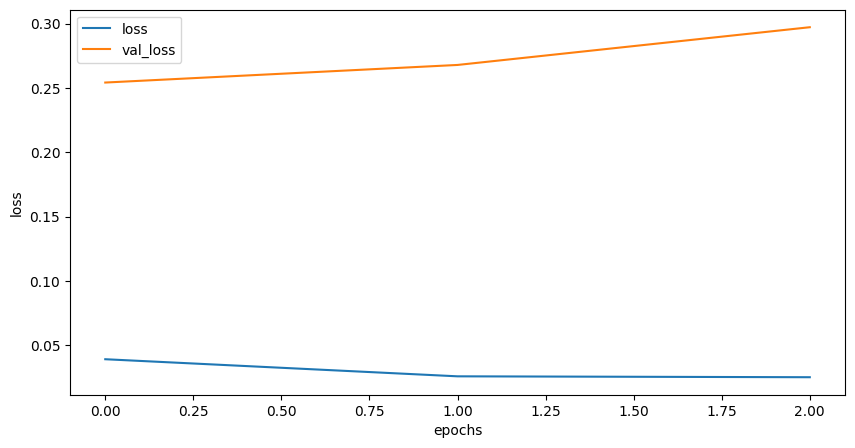

In [61]:
metrics = history.history

plt.figure(figsize = (10 , 5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss' , 'val_loss'])
plt.show()

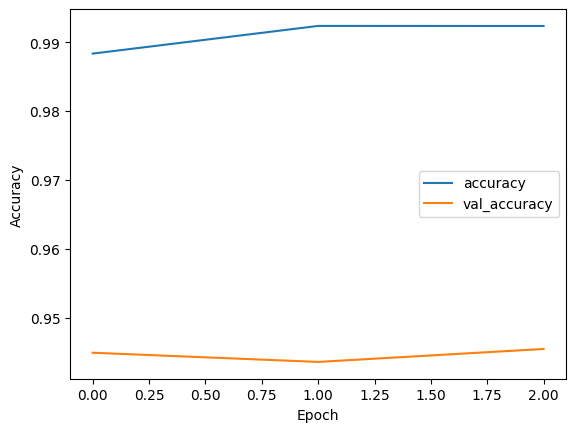

In [62]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [63]:
tweet = ["This movie is fantastic!"]
seq = tokenizer.texts_to_sequences(tweet)
sample_pad = pad_sequences(seq, maxlen=100)

prediction = model.predict(sample_pad)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
Prediction: [[0.9975387]]
